In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
sys.path.insert(0, '..') #add paernet directory to the list in which packages are searched

In [3]:
from funcs import getParMtxPerBundle_Silic, getParMtxPerBundle_Scint, getModulesPerBundle

Welcome to JupyROOT 6.24/00


In [4]:
with open('../input/allocation/allocation_20210616_14bundles.txt') as f:
    lines = [line.rstrip('\n') for line in f]
f.close()

In [5]:
bundlesSil = getModulesPerBundle(lines, isScintil=False)
bundlesScint = getModulesPerBundle(lines, isScintil=True)

In [6]:
parMtxEM_PerBundle, parMtxHadSil_PerBundle = getParMtxPerBundle_Silic(bundlesSil, '../output/tower_module_mapping_array/', 'param_mtx_em.pkl', 'param_mtx_had_silic.pkl')


In [7]:
parMtxHadScint_PerBundle = getParMtxPerBundle_Scint(bundlesScint, '../output/tower_module_mapping_array/', 'param_mtx_had_scint.pkl')



In [8]:
parMtxHad_PerBundle = {}
for i in range(len(bundlesScint)):
    parMtxHad_PerBundle[i] = pd.concat([parMtxHadSil_PerBundle[i],parMtxHadScint_PerBundle[i]], axis=1).fillna(0)

In [9]:
indicesEM = [idx[3:] for idx in parMtxEM_PerBundle[0].index]
indicesHad = [idx[4:] for idx in parMtxHad_PerBundle[0].index]

In [10]:
#indices = indicesEM + list(set(indicesHad) - set(indicesEM))

In [11]:
def make_df(parMtx_PerBundle, indices, isHad): #isHad is True for CE-H and False otherwise
    name = 'Had' if isHad else 'EM'
    cutIndex = 4 if isHad else 3
    df = pd.DataFrame({name:np.zeros(len(indices))}, index = indices).astype(int)
    for bundle in parMtx_PerBundle: #0,1,...,23
        towers = [tower[cutIndex:] for tower in \
                  parMtx_PerBundle[bundle][(parMtx_PerBundle[bundle] != 0).any(axis=1)].index]
        df.loc[df.index.isin(towers), name] += 1
    return df

def find_eta(name):
    return int(name[name.find('eta')+3 : name.find('-phi')])

def find_phi(name):
    return int(name[name.find('-phi')+4:])

def remove_phi(name):
    return name[:name.find('-phi')+4]

def plotHist(data, Name, binwidth=1, low_lim=1):
    """
    These plots show how many S1 FPGAs are invloved for making a full partial tower
    from fractional partial towers. This tells us how many sums are needed in S2 FPGAs.
    """
    data=data[data!=0]
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }
    #title = 'CE-E' if data.name=='EM' else 'CE-H'
    print('mean = ', round(data.mean(), 2))
    print('maximum = ', data.max())
    print('total entries = ', len(data))
    bins=np.arange(low_lim, max(data) + 2*binwidth, binwidth)
    plt.hist(data, bins, ec='black')
    plt.xticks(bins[::2])
    plt.xlabel('number of Stage 1 FPGAs sending partial towers')
    plt.ylabel('number of partial towers')
    #plt.title(title)
    plt.savefig('numOfStage1FPGAsSendingTower_' + Name + '.png', dpi=300)
    
def divideByRepeat(df):
    df_countedOnce = df.copy()
    countedTwice = {}
    for tower in df.index:
        if (find_phi(tower) < 0) | (find_phi(tower) > 23):
            if(remove_phi(tower) + str(find_phi(tower) % 24) in df.index):
                nameMerged = remove_phi(tower)+str(find_phi(tower))+'/'+str(find_phi(tower) % 24)
                name1 = tower
                name2 = remove_phi(tower)+str(find_phi(tower) % 24)
                countedTwice[nameMerged] = int(df.loc[name1] + df.loc[name2])
                df_countedOnce = df_countedOnce.drop([name1, name2])
    df_countedTwice = pd.DataFrame(pd.Series(countedTwice), columns = df.columns)
    return df_countedOnce, df_countedTwice
    
def divideBy30deg(df):
    below30 = {}
    above30 = {}
    for tower in df.index:
        if int(find_phi(tower))<6: #30 degrees
            below30[tower] = int(df.loc[tower])
        else:
            above30[tower] = int(df.loc[tower])
    df_below30 = pd.DataFrame(pd.Series(below30), columns = df.columns)
    df_above30 = pd.DataFrame(pd.Series(above30), columns = df.columns)
    
    return df_below30, df_above30

def numTowersPerBundle(parMtx_PerBundle, name):
    below30 = {}
    above30 = {}
    for bundle in parMtx_PerBundle: #0,1,...,23
        below30[bundle] = 0
        above30[bundle] = 0
        df = parMtx_PerBundle[bundle][(parMtx_PerBundle[bundle] != 0).any(axis=1)]
        for tower in df.index:
            if find_phi(tower)<6: # 30 degrees
                below30[bundle] += 1
            else:
                above30[bundle] += 1
    df_below30 = pd.DataFrame(pd.Series(below30), columns = [name])
    df_above30 = pd.DataFrame(pd.Series(above30), columns = [name])
    return df_below30, df_above30

def plotHist2(df, Name):
    name = df.columns[0]
    #title = 'CE-E' if name=='EM' else 'CE-H'
    print('mean = ', round(df[name].mean(), 2))
    print('maximum = ', df[name].max())
    fig, ax = plt.subplots()
    ax.bar(df.index, df[name])
    ax.set_ylabel('number of partial towers')
    ax.set_xlabel('stage 1 FPGA label')
    #ax.set_title(title)
    plt.savefig('numOfTowersPerStage1FPGA_' + Name + '.png', dpi=300)

In [12]:
df_EM = make_df(parMtxEM_PerBundle, indicesEM, isHad = False)
df_Had = make_df(parMtxHad_PerBundle, indicesHad, isHad = True)

In [13]:
df_countedOnceEM, df_countedTwiceEM = divideByRepeat(df_EM)

In [14]:
df_countedOnceHad, df_countedTwiceHad = divideByRepeat(df_Had)

In [15]:
df_countedOnceEM_below30, df_countedOnceEM_above30 = divideBy30deg(df_countedOnceEM)

In [16]:
df_countedOnceHad_below30, df_countedOnceHad_above30 = divideBy30deg(df_countedOnceHad)

mean =  9.07
maximum =  14
total entries =  122


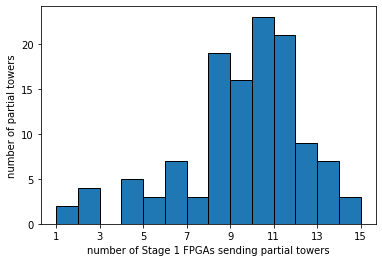

In [17]:
plotHist(df_countedOnceEM_below30['EM'], 'countedOnceEM_below30')

mean =  9.46
maximum =  14
total entries =  286


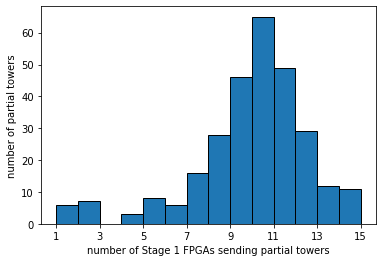

In [18]:
plotHist(df_countedOnceEM_above30['EM'], 'countedOnceEM_above30')

mean =  14.0
maximum =  19
total entries =  10


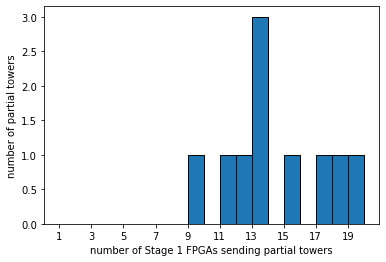

In [19]:
plotHist(df_countedTwiceEM['EM'], 'countedTwiceEM')

mean =  9.65
maximum =  14
total entries =  102


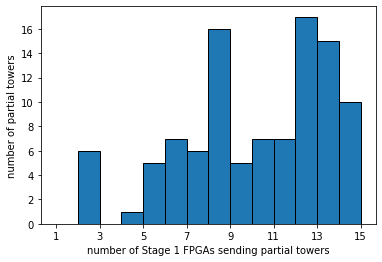

In [20]:
plotHist(df_countedOnceHad_below30['Had'], 'countedOnceHad_below30')

mean =  9.7
maximum =  14
total entries =  343


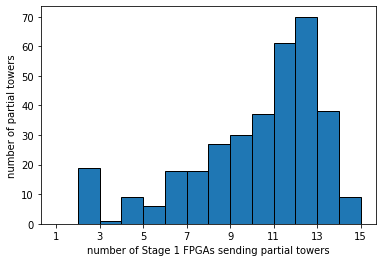

In [21]:
plotHist(df_countedOnceHad_above30['Had'], 'countedOnceHad_above30')

mean =  13.03
maximum =  18
total entries =  35


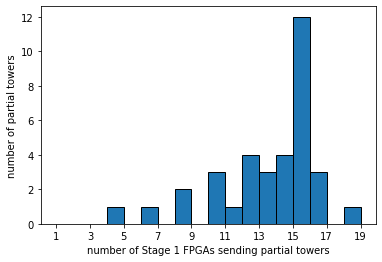

In [22]:
plotHist(df_countedTwiceHad['Had'], 'countedTwiceHad')

In [23]:
towersPerBundle_EM_below30, towersPerBundle_EM_above30 = numTowersPerBundle(parMtxEM_PerBundle, 'EM')

In [24]:
towersPerBundle_Had_below30, towersPerBundle_Had_above30 = numTowersPerBundle(parMtxHad_PerBundle, 'Had')

mean =  84.29
maximum =  104


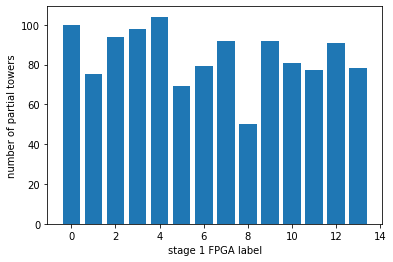

In [25]:
plotHist2(towersPerBundle_EM_below30, 'EM_below30')

mean =  197.93
maximum =  221


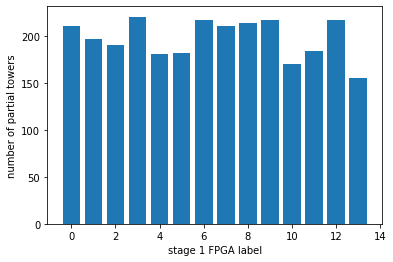

In [26]:
plotHist2(towersPerBundle_EM_above30, 'EM_above30')

mean =  86.29
maximum =  117


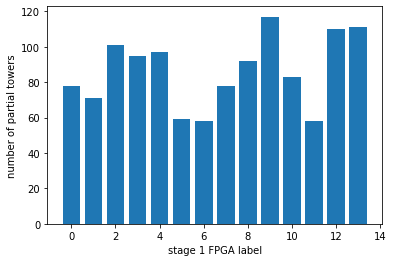

In [27]:
plotHist2(towersPerBundle_Had_below30, 'Had_below30')

mean =  254.29
maximum =  298


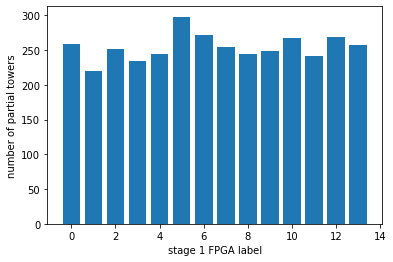

In [28]:
plotHist2(towersPerBundle_Had_above30, 'Had_above30')

In [29]:
towersPerBundle_HadPlusEM_above30 = pd.DataFrame(towersPerBundle_EM_above30['EM'] + towersPerBundle_Had_above30['Had'], columns = ['HadPlusEM'])

In [30]:
towersPerBundle_HadPlusEM_below30 = pd.DataFrame(towersPerBundle_EM_below30['EM'] + towersPerBundle_Had_below30['Had'], columns = ['HadPlusEM'])

mean =  170.57
maximum =  209


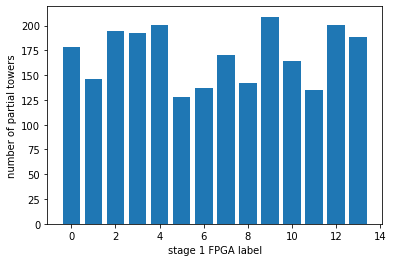

In [31]:
plotHist2(towersPerBundle_HadPlusEM_below30, 'HadPlusEM_below30')

mean =  452.21
maximum =  489


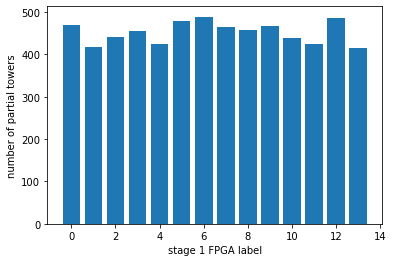

In [32]:
plotHist2(towersPerBundle_HadPlusEM_above30, 'HadPlusEM_above30')